# **Deep Research with Bing Search & Scraping**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow now includes a dedicated scraping phase for extracting and cleaning web content:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Web Content Scraping** - Extracting, cleaning, and filtering relevant content from web pages using a ScraperAgent
4. **Content Analysis** - Summarizing scraped results and extracting key insights
5. **Report Generation** - Creating detailed research reports with proper citations
6. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- WebScraperAgent - Extracts, cleans, and filters relevant content from web pages
- SummaryAgent - Extracts key insights from scraped content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [1]:
import os
import dotenv

dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class ScrapedWebPage(BaseModel):
    url: str = Field(..., description="The original URL that was scraped")
    title: Optional[str] = Field(None, description="The page title (if available, else None)")
    main_content: Optional[str] = Field(None, description="The main textual content of the page, cleaned and potentially truncated (if available, else None)")
    source: Optional[str] = Field(None, description="The name of the source (if available, else None)")
    published_date: Optional[str] = Field(None, description="YYYY-MM-DD (if available, else None)")
    scrape_error: Optional[str] = Field(None, description="Error message if scraping failed, else None")
    # Fields below might be added by the agent based on instructions, not the tool directly
    extraction_method: Optional[str] = Field(None, description="How content was extracted (e.g., 'tool_extracted', 'agent_filtered')") 
    relevance_score_agent: Optional[float] = Field(None, description="Agent's assessment of relevance (0-10)")
    matched_sections: Optional[List[str]] = Field(None, description="Sections identified by the agent as relevant")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["PROJECT_CONNECTION_STRING"],
)

The following cell will ***create*** an **Azure AI Agent**, so you only need to run this cell **once**.

In [5]:
# from azure.ai.projects.models import BingGroundingTool

# bing_connection = project_client.connections.get(
#     connection_name=os.environ["BING_CONNECTION_NAME"]
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="BingSearchAgent",
#     description="Agent to perform web searches using Bing.",
#     model="gpt-4o",
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions="""You are a helpful research assistant. 
# Use your available tools (like Bing web search) to find information relevant to the user's query.
# When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
# Provide a comprehensive answer based on the search results."""
# )

**OpenAI Agents**

In [ ]:
from agents import (
    Agent,
    ModelSettings
)

from common.utils_scraping import scrape_web_page

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions="""
    You are an expert research planner specializing in creating detailed research plans
    Your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 4 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 2 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """,
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

web_scraper_agent = Agent(
    name="WebScraperAgent",
    instructions=f"""
    You are a robust, context-aware web scraping specialist. Your primary tool is 'scrape_web_page'.

    Your input is a JSON string containing: 'url', 'subtopic', 'user_query', 'search_result_title', 'visited_urls', and 'max_content_length'. Parse this JSON to get the necessary information.

    **Workflow:**
    1.  **Parse Input:** Extract 'url', 'user_query', 'subtopic', 'search_result_summary', and 'max_content_length' from the input JSON string.
    2.  **Call Scraping Tool:** Call the `scrape_web_page` tool with the 'url' and 'max_content_length'.
    3.  **Analyze Tool Output:** Receive the dictionary from the tool containing `url`, `title`, `main_content`, `source`, `published_date`, `scrape_error`.
    4.  **Contextual Filtering (If Content Exists and No Error):**
        - If `scrape_error` is None and `main_content` exists:
            - Review the `main_content`.
            - Use the `user_query`, `subtopic`, and `search_result_summary` to identify ONLY the most relevant paragraphs or sections.
            - If the entire `main_content` seems relevant or is short, keep it all.
            - If filtering, replace `main_content` with ONLY the relevant extracted parts. Set `extraction_method` to 'agent_filtered'.
            - Estimate a `relevance_score_agent` (0-10).
            - Optionally list `matched_sections`.
        - If `scrape_error` is present, ensure the `scrape_error` field in your output reflects the tool's error.
    5.  **Format Output:** Return a SINGLE JSON object matching the `ScrapedWebPage` Pydantic model, including all fields based on the tool's output and your filtering. If the tool failed, `main_content` should be None/empty, and `scrape_error` should be set.
    6.  **Return JSON object:** Return ONLY the final object formatted as a single, valid JSON. Do NOT add any explanatory text before or after the JSON.

    **Constraints:**
    - Your final output MUST be ONLY a valid JSON representing the scraped and processed data.
    - Adhere strictly to the field names defined in the conceptual `ScrapedWebPage` structure when creating the JSON.
    - Prioritize accuracy and relevance based on the provided context.
    """,
    model=chatModel,
    model_settings=chatModelSettings,
    tools=[scrape_web_page],
    output_type=ScrapedWebPage
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)


peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)

**hand-offs**

In [7]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Web Content Scraping** → WebScraperAgent extracts, cleans, and filters relevant content from web pages
5. **Analysis** → SummaryAgent processes scraped results, extracting key insights while preserving technical details
6. **Synthesis** → ResearchAgent creates well-structured report with proper citations
7. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
8. **Revision** → If needed, research report undergoes improvement cycles based on feedback
9. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

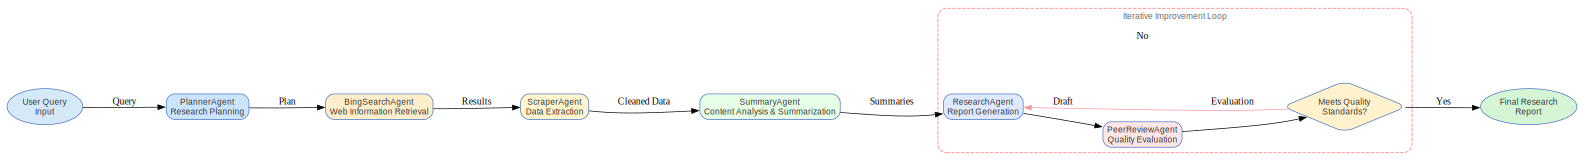

In [8]:
from common.helper import create_research_workflow_diagram_scraper

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram_scraper()
workflow_diagram

Let's start with a sample research query.

In [9]:
user_query="What's the latest news in the field of AI? And what big industries will be affected by it?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [10]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [ ]:
plan.final_output.research_tasks[0].search_queries

['latest artificial intelligence news 2024',
 'recent AI breakthroughs 2024',
 'top AI research papers 2024',
 'AI industry updates June 2024',
 'emerging trends in AI technology']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. Multiple search queries are sent to gather diverse perspectives.
2. The agent returns structured search results with titles, summaries, relevance scores, and URLs.
3. Results are organized by subtopic for further processing.

This step leverages Azure AI Projects with Bing Search integration to identify promising sources.

In [12]:
import os
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.create_thread()
            message = project_client.agents.create_message(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.create_and_process_run(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.delete_thread(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 7/7 [06:14<00:00, 53.47s/it]


In [13]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 35

Actually total search queries: 35



### Step 3: Web Content Scraping

The WebScraperAgent processes the URLs and metadata returned by the BingSearchAgent. For each subtopic:

1. Only URLs with a high enough relevance score are selected for scraping.
2. The WebScraperAgent visits each selected URL and extracts the most relevant content, guided by the user query, subtopic, and search result summary.
3. Extracted content is cleaned, deduplicated, and enriched with metadata such as title, source, published date, and extraction method.
4. The resulting structured data is organized by subtopic for downstream analysis and summarization.

This step ensures that only the most promising and contextually relevant web content is collected, providing a high-quality foundation for subsequent summarization and synthesis.

In [14]:
from typing import Set

class ScraperAgentInput(BaseModel):
    url: str
    subtopic: str
    user_query: str
    search_result_title: str
    visited_urls: Set[str] = Field(default_factory=set)
    max_content_length: int = 4000

In [15]:
# TODO: Implement a threshold for relevance score 

# --- Scraping Phase ---
urls_to_process_map = {}

print("Preparing scrape tasks...")
for subtopic_result in search_results:
    subtopic = subtopic_result["subtopic"]
    for query_result in subtopic_result["queries"]:
        query = query_result["query"]
        for result in query_result["results"]:
            if result["url"] not in urls_to_process_map:
            # if result.relevance_score >= MIN_RELEVANCE_SCORE and result.url not in urls_to_process_map:
                urls_to_process_map[result["url"]] = {
                    "subtopic": subtopic,
                    "query": query,
                    "search_result_title": result["title"]
                }

visited_urls_tracker = set(urls_to_process_map.keys())
print(f"Found {len(urls_to_process_map)} unique URLs above threshold to scrape.")

Preparing scrape tasks...
Found 70 unique URLs above threshold to scrape.


In [16]:
from itertools import islice

MAX_SCRAPE_CONTENT_LENGTH = 4000 # Max characters for scrape tool

scrape_tasks = []
num_urls_to_scrape = len(urls_to_process_map)

for url, context in tqdm(islice(urls_to_process_map.items(), num_urls_to_scrape),
                         desc="Preparing scrape tasks",
                         total=num_urls_to_scrape):
    agent_input_model = ScraperAgentInput(
        url=url,
        subtopic=context["subtopic"],
        user_query=context["query"],
        search_result_title=context["search_result_title"],
        visited_urls=visited_urls_tracker,
        max_content_length=MAX_SCRAPE_CONTENT_LENGTH
    )

    scrape_response = await Runner().run(
        starting_agent=web_scraper_agent,
        input=f"Scrape data from the provided URL: {agent_input_model.model_dump_json()}"
    )
    scrape_tasks.append(scrape_response.final_output)

Preparing scrape tasks:   0%|          | 0/70 [00:00<?, ?it/s]WARNING:trafilatura.utils:invalid ZSTD file
ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None
ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
Preparing scrape tasks:   1%|▏         | 1/70 [00:04<05:11,  4.52s/it]WARNING:trafilatura.utils:invalid ZSTD file
ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None
ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
Preparing scrape tasks:  29%|██▊       | 20/70 [05:27<17:42, 21.26s/it]WARNING:trafilatura.utils:invalid ZSTD file
ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None
ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
Preparing scrape tasks:  36%|███▌      | 25/

### Step 4: Content Analysis and Summarization

For each scraped result, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the cleaned web content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms high-quality scraped data into structured, information-rich summaries that will form the basis of our research report.

In [18]:
from common.utils_summary import collect_contents_and_citations, summarize_content
summarize_per_webpage = False  # True will summarize per web page, False will summarize per subtopic

# Build a lookup for scraped content (using attribute access)
scraped_content_by_url = {
    item.url: item.main_content
    for item in scrape_tasks
    if getattr(item, "main_content", None)
}

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    contents, citations = collect_contents_and_citations(subtopic_result, scraped_content_by_url)
    summaries = await summarize_content(contents, summary_agent, Runner, summarize_per_webpage)
    if summarize_per_webpage:
        mapped_chunks.append({
            "subtopic": subtopic_result["subtopic"],
            "summaries": summaries,
            "citations": citations
        })
    else:
        mapped_chunks.append({
            "subtopic": subtopic_result["subtopic"],
            "summaries": summaries,
            "citations": citations
        })

# Filter out empty summaries
mapped_chunks = [c for c in mapped_chunks if c['summaries']]

Summarizing subtopics: 100%|██████████| 7/7 [02:33<00:00, 21.88s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [19]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [20]:
from agents import HandoffCallItem

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [21]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# Artificial Intelligence in 2024–2025: Breakthroughs, Industry Transformations, and Societal Implications

## Introduction

Artificial intelligence (AI) has entered a period of unprecedented acceleration, marked by transformative breakthroughs in foundational models, generative capabilities, and agentic systems. The years 2024 and 2025 are shaping up to be watershed moments, not only for the technology itself but also for its sweeping impact across virtually every major industry. This report provides a comprehensive analysis of the most recent and significant advances in AI, synthesizes their implications for key sectors, and critically examines both the opportunities and challenges that lie ahead. Drawing on primary sources, industry reports, and expert commentary, the report aims to offer a nuanced, authoritative perspective on the evolving AI landscape.

## 1. Recent Breakthroughs and News in AI

The past 12 months have witnessed a flurry of AI innovations, with leading technology companies and research institutions pushing the boundaries of what is possible. Among the most notable developments are the following:

### 1.1 The Gemini Series and the Agentic Era

Google's 2024 release of the Gemini 2.0 series marked a pivotal shift toward agentic AI—models capable not only of generating content but also of autonomous planning, reasoning, and action-taking. The Gemini 2.0 Flash model, optimized for both performance and efficiency, became a workhorse for a variety of applications, while experimental projects such as Project Astra (universal AI assistant), Project Mariner (AI taking actions within Chrome), and Jules (AI-powered code agent) showcased the potential for specialized, context-aware AI agents. These advances were rapidly integrated into flagship products, with Gemini-powered AI Overviews in Search serving over a billion users and features like Deep Research automating complex, multi-step information retrieval tasks [1][2].

### 1.2 Open Models and Community-Driven Innovation

Continuing its tradition of open-source leadership, Google released the Gemma family of models, which outperformed similarly sized open models in benchmarks for question answering, reasoning, mathematics, and coding. The introduction of Gemma Scope provided researchers with tools to probe model internals, enhancing transparency and fostering community-driven research. These efforts signal a broader industry trend toward democratizing access to advanced AI capabilities, narrowing the gap between proprietary and open-source systems [1][2].

### 1.3 AI for Societal Benefit: AlphaFold 3 and Global Challenges

AI's impact has extended well beyond consumer products. The unveiling of AlphaFold 3, capable of predicting the structure and interactions of all of life’s molecules, represents a breakthrough with profound implications for biology, medicine, and drug discovery. In parallel, AI-driven health initiatives have connected users to critical information, while global-scale applications such as flood forecasting demonstrate AI’s potential for disaster mitigation and climate resilience [1][2].

### 1.4 Infrastructure, Education, and Responsible AI

Recognizing the importance of responsible development, Google and other leaders have invested heavily in AI infrastructure, developer resources, and educational initiatives. The AI Opportunity Fund and Essentials course aim to democratize AI skills, supporting workforce development and digital inclusion. New generative AI tools in Labs, alongside resources for ethical research and deployment, underscore the industry’s commitment to safe, transparent, and equitable AI [1][2].

### 1.5 Economic and Technical Milestones

The cost of training state-of-the-art models has soared—Google’s Gemini 1.0 Ultra reportedly cost $192 million—while the cost of inference (model usage) has plummeted, democratizing access to AI capabilities. The United States remains the leader in influential AI model output, but global competition is intensifying, with China and Europe making significant strides. Open-source models are rapidly closing the performance gap with proprietary systems, intensifying competition and accelerating innovation [3][4].

#### Table 1: Timeline of Major AI Developments (2024–2025)

| Date         | Breakthrough/News                                 | Description/Impact                                         |
|--------------|---------------------------------------------------|------------------------------------------------------------|
| Early 2024   | Gemini 1.5 Pro/Flash released                     | Compact, efficient models for broad developer adoption      |
| Mid 2024     | Gemma open models launched                        | Outperformed peers, enhanced transparency                   |
| Late 2024    | Gemini 2.0 and agentic prototypes (Astra, Mariner)| Autonomous planning, reasoning, action-taking               |
| 2024         | AlphaFold 3 announced                             | Molecular prediction for biology and medicine               |
| 2024         | AI Overviews in Search (Gemini-powered)           | Serves >1 billion users, new search paradigms               |

## 2. Major Industries Impacted by AI

AI’s transformative reach now extends across virtually every sector of the global economy. The following sections provide a comprehensive analysis of at least five major industries undergoing significant change due to recent AI advancements, drawing on case studies, expert forecasts, and quantitative data.

### 2.1 Healthcare

Healthcare stands at the forefront of AI-driven transformation. AI-powered diagnostic tools, such as those for medical imaging and cancer detection, are now outperforming human experts in certain tasks. The U.S. FDA approved 223 AI-based medical devices in 2023 alone, signaling mainstream adoption. Wearable devices and remote monitoring systems leverage AI for real-time health tracking, while AI-driven drug discovery platforms like AlphaFold 3 are accelerating the identification of novel therapeutics. Robotic surgeries, personalized treatment plans, and AI-assisted triage are becoming standard in leading hospitals. However, these advances bring challenges related to privacy, algorithmic bias, and regulatory compliance, necessitating robust ethical frameworks and transparent governance [3][5][6].

### 2.2 Finance and Banking

AI has become a central force in banking and fintech, underpinning operational transformation, customer engagement, and risk management. Generative AI alone could add $200–$340 billion annually to global banking, representing 2.8–4.7% of industry revenues, with broader AI potentially unlocking over $1 trillion in annual value by 2030. Core applications include fraud detection, risk management, customer service automation, credit assessment, and regulatory compliance. AI-driven chatbots and robo-advisors are democratizing financial advice, while causal AI and explainable models are addressing the “black box” problem. The sector faces challenges around data privacy, algorithmic fairness, regulatory uncertainty, and talent shortages, but the trajectory toward an AI-driven paradigm is clear [7][8][9][10].

### 2.3 Manufacturing and Supply Chain

Manufacturing and supply chain operations are being revolutionized by AI-powered automation, predictive maintenance, and real-time analytics. By 2024, up to 88% of manufacturers had implemented AI, and 65% of organizations were regularly using generative AI. AI-driven quality control systems, robotics, and digital twins are boosting productivity, reducing costs, and enabling mass customization. Supply chain optimization, demand forecasting, and logistics automation are driving efficiency and resilience, with AI-optimized routing reducing fuel consumption by over 15% annually. However, high implementation costs, data quality issues, and talent shortages remain significant barriers, while the environmental impact of AI chip manufacturing is an emerging concern [11][12][13][14].

### 2.4 Retail and E-commerce

Retail is undergoing a digital transformation, with AI powering hyper-personalization, predictive analytics, and advanced inventory management. AI-driven recommendation engines, chatbots, and virtual assistants are enhancing customer experiences and driving revenue growth. Inventory management systems leveraging AI have reduced forecasting errors by up to 50%, while omnichannel fulfillment ensures real-time synchronization across physical and digital channels. Retailers face challenges in skills development, data management, and consumer trust, but those that effectively harness AI are achieving significant operational efficiencies and deeper customer relationships [15][16][17][18].

### 2.5 Transportation and Automotive

The integration of AI and autonomous vehicles is fundamentally transforming transportation. AI-powered perception, control systems, and predictive analytics are enabling safer, more efficient, and sustainable mobility. Autonomous vehicles, smart infrastructure, and AI-optimized logistics are reducing accidents, fuel consumption, and maintenance costs. The logistics sector is experiencing rapid growth in AI adoption, with benefits including enhanced supply chain resilience and real-time visibility. However, challenges related to regulatory frameworks, cybersecurity, and real-world validation persist, requiring ongoing investment and robust policy development [19][20][21][22].

#### Table 2: Impact Assessment Matrix Across Industries

| Industry         | Key AI Applications                   | Economic Impact (2024–2025)                | Challenges                        |
|------------------|--------------------------------------|---------------------------------------------|------------------------------------|
| Healthcare       | Diagnostics, drug discovery, robotics| $100B+ market, improved outcomes            | Privacy, bias, regulation          |
| Finance/Banking  | Fraud detection, automation, GenAI   | $200–340B annual value, $1T by 2030         | Data privacy, fairness, regulation |
| Manufacturing    | Predictive maintenance, robotics     | $20.8B market by 2028, 20–30% ROI           | Cost, data, talent, sustainability |
| Retail/E-commerce| Personalization, inventory, chatbots | $40.5B market by 2025, 10% revenue growth   | Skills, data, trust                |
| Transportation   | Autonomous vehicles, logistics       | $6.5B logistics AI market by 2031           | Regulation, cybersecurity          |

## 3. In-Depth Industry Analyses

### 3.1 Healthcare: Promise and Peril

AI’s impact on healthcare is multifaceted and profound. Diagnostic assistance programs, such as AI-powered radiology and pathology tools, are now outperforming human clinicians in tasks like cancer detection from imaging. The FDA’s approval of 223 AI-based medical devices in 2023 underscores the mainstreaming of AI in clinical practice. Wearable devices and remote monitoring platforms use AI to provide continuous health tracking, enabling early intervention and personalized care. AlphaFold 3’s ability to predict molecular structures is accelerating drug discovery and the development of targeted therapies.

Robotic surgeries, guided by AI, are reducing complications and improving patient outcomes. AI-driven triage systems and virtual health assistants are streamlining patient flow and enhancing access to care. However, these advances raise critical concerns. Privacy and data security are paramount, given the sensitivity of health data. Algorithmic bias can lead to disparities in care, particularly for underrepresented populations. Regulatory frameworks are struggling to keep pace with rapid innovation, necessitating ongoing dialogue between technologists, clinicians, and policymakers. The future of AI in healthcare will depend on the development of transparent, explainable models and robust ethical guidelines [3][5][6].

### 3.2 Finance and Banking: Toward an AI-Driven Paradigm

The financial sector is experiencing a paradigm shift as AI moves from peripheral innovation to a central driver of strategy and operations. Generative AI alone could contribute $200–$340 billion annually to banking, primarily through productivity gains and operational efficiencies. AI-powered process automation, fraud detection, and risk management are now standard in leading institutions. For example, NatWest achieved a 90% reduction in new account fraud since 2019 through AI-driven systems, while HSBC uses AI for rapid risk alerts.

Customer engagement is being transformed by AI-driven chatbots and virtual assistants, such as Bank of America’s Erica, which provide 24/7 support and personalized recommendations. Robo-advisors, managing over $4.6 trillion in assets globally, are democratizing investment advice. AI-augmented credit scoring and underwriting are enabling more accurate and inclusive lending decisions, while NLP tools automate compliance and regulatory reporting.

The sector is also witnessing a shift toward centralized operating models for GenAI, enabling better talent allocation, risk management, and scalability. However, challenges persist. Data privacy and security are critical, given the sensitivity of financial data. Algorithmic bias and fairness remain concerns, particularly in credit and lending decisions. Regulatory uncertainty and talent shortages are ongoing issues, while over-reliance on automation raises questions about workforce displacement and the need for upskilling. The future will see further integration of AI with blockchain, the rise of voice banking, and predictive global market models, with regulation and ethical AI shaping the pace and direction of innovation [7][8][9][10].

### 3.3 Manufacturing and Supply Chain: Toward Autonomous Operations

AI adoption in manufacturing and supply chain operations has surged, with up to 88% of manufacturers implementing AI and 65% regularly using generative AI. Predictive maintenance algorithms analyze equipment data to forecast failures, reducing downtime and maintenance costs by up to 10%. Machine learning and computer vision systems have pushed quality control accuracy from 50% to 99% in under a decade, minimizing waste and ensuring higher product quality.

AI enhances supply chain optimization, demand forecasting, and logistics, leading to more efficient and resilient operations. For instance, a global e-commerce company automated 80–90% of its demand forecasting, achieving a 15x improvement in accuracy. AI-powered robots and autonomous mobile robots (AMRs) are transforming assembly, packaging, and warehouse logistics, improving speed and throughput.

The business case for AI is compelling, with companies reporting average ROIs of 20–30% within the first few years. AI-driven supply chains are projected to cut operational costs by up to 30% and reduce lead times by 40% over the next five years. However, high implementation costs, data quality issues, and talent shortages remain significant barriers. The environmental impact of AI chip manufacturing is an emerging concern, with global energy consumption for AI chip production projected to surpass Ireland’s total consumption by 2030. Addressing these challenges will require robust data infrastructure, workforce upskilling, and a commitment to sustainable practices [11][12][13][14].

### 3.4 Retail and E-commerce: Hyper-Personalization and Operational Excellence

AI is revolutionizing retail through hyper-personalization, predictive analytics, and advanced inventory management. AI-driven recommendation engines, such as those used by Amazon, account for up to 35% of purchases, while chatbots and virtual assistants are enhancing customer experiences and driving revenue growth. AI-powered inventory management systems have reduced forecasting errors by up to 50% and enabled real-time, omnichannel fulfillment.

Consumers increasingly expect seamless, omnichannel, and hyper-personalized experiences, with a strong preference for a blend of AI and human interaction. Retailers using AI-driven personalization tactics report revenue growth up to 10% faster than peers. However, challenges remain. Skills gaps, data management, and consumer trust are significant hurdles, with only about one-third of consumers fully trusting AI tools for product information. Addressing these challenges will require investment in talent development, robust data management, and transparent communication about data practices. The future of retail will be defined by the convergence of AI, automation, and immersive technologies such as AR/VR, with hyper-personalization and predictive analytics at the core of customer experience [15][16][17][18].

### 3.5 Transportation and Automotive: The Autonomous Revolution

The transportation sector is undergoing a profound transformation driven by AI and autonomous vehicle technologies. AI-powered perception and control systems are enabling safer, more efficient, and sustainable mobility. Autonomous vehicles, equipped with sophisticated sensors and deep learning algorithms, are reducing human error and enabling smoother travel. AI-driven features such as adaptive cruise control, lane departure warnings, and collision avoidance are already enhancing road safety, while fully self-driving cars and trucks are on the cusp of widespread deployment.

The rise of electric vehicles (EVs) is closely intertwined with AI-driven transportation, with AI optimizing energy management, route planning, and vehicle performance. Smart infrastructure, including connected traffic signals and AI-powered monitoring systems, is facilitating seamless communication between vehicles and their environment. The logistics sector is experiencing rapid growth in AI adoption, with benefits including reduced fuel consumption, lower maintenance costs, improved safety, and enhanced supply chain resilience.

However, significant challenges remain. Regulatory uncertainty, cybersecurity, and the need for robust validation are critical hurdles. The gap between theoretical advancements and real-world implementation is a persistent issue, necessitating ongoing investment in policy development and technical validation. The future of transportation will be defined by the convergence of autonomous vehicles, electric mobility, smart infrastructure, and AI-powered logistics, delivering safer, more efficient, and more sustainable systems [19][20][21][22].

## 4. Expert Opinions and Future Trends

Expert consensus holds that 2025 will be a pivotal year for AI adoption, with generative AI, automation, and advanced analytics driving industry-wide transformation. The Stanford AI Index 2025 highlights the United States’ continued leadership in influential AI model output, but notes intensifying global competition, particularly from China. The cost of AI training is soaring, but inference costs are plummeting, accelerating adoption and democratizing access to advanced capabilities [3][4].

Open-source AI models are rapidly closing the performance gap with proprietary systems, making advanced AI more accessible and intensifying global competition. However, the carbon footprint of large-scale AI remains a concern, as data center energy consumption continues to rise despite gains in efficiency.

AI-driven automation is projected to affect up to 800 million jobs globally by 2030, with both blue- and white-collar roles at risk. The need for upskilling and reskilling is urgent, as new roles emerge in AI oversight, data analysis, and human-AI collaboration. Surveys indicate that while 65% of CEOs view AI as a force for good, an equal proportion recognize the need for stronger safeguards around ethics, privacy, and security [3][4].

Despite remarkable technical progress, AI still struggles with complex reasoning and multi-step logic, limiting its reliability in high-stakes domains. Ethical dilemmas, regulatory uncertainty, and societal adaptation lag behind technological advances. The proliferation of synthetic media and adversarial attacks underscores the need for robust governance and public trust.

## 5. Positive and Negative Implications of AI

### 5.1 Positive Implications

AI’s benefits are manifold. In healthcare, AI is improving diagnostic accuracy, accelerating drug discovery, and enabling personalized medicine. In finance, AI is enhancing fraud detection, risk management, and financial inclusion. Manufacturing and supply chain operations are becoming more efficient, resilient, and sustainable. Retailers are delivering hyper-personalized experiences and achieving significant revenue growth. Transportation systems are becoming safer, more efficient, and more sustainable.

AI is also democratizing access to advanced capabilities, enabling smaller organizations and individuals to leverage powerful tools. Open-source models and community-driven innovation are fostering transparency, collaboration, and rapid progress. AI-driven education and workforce development initiatives are supporting digital inclusion and economic mobility.

### 5.2 Negative Implications

However, AI’s rapid advancement brings significant risks. Workforce displacement is a major concern, with up to 800 million jobs at risk by 2030. Algorithmic bias and fairness issues can exacerbate existing inequalities, particularly in high-stakes domains such as healthcare and finance. Data privacy and security are critical challenges, especially as AI systems handle increasingly sensitive information.

The environmental impact of AI, particularly in chip manufacturing and data center energy consumption, is an emerging concern. Regulatory frameworks are struggling to keep pace with technological innovation, leading to uncertainty and potential risks. The proliferation of synthetic media and adversarial attacks threatens public trust and societal stability, underscoring the need for robust governance and ethical guidelines.

## 6. Conclusion

The years 2024 and 2025 represent a turning point in the evolution of artificial intelligence. Breakthroughs in foundational models, generative capabilities, and agentic systems are driving rapid, industry-wide transformation. Healthcare, finance, manufacturing, retail, and transportation are experiencing both operational breakthroughs and structural disruptions, with AI-powered tools becoming mainstream and reshaping value chains.

The path forward requires a balanced approach, integrating responsible AI governance, proactive workforce strategies, and ongoing investment in both technical and human capital. The benefits of AI—efficiency, innovation, and new business models—are matched by significant challenges: workforce disruption, ethical risks, regulatory gaps, and sustainability concerns. Realizing AI’s transformative potential will depend on the development of transparent, explainable models, robust ethical guidelines, and inclusive governance frameworks.

As AI continues to evolve, its integration into every facet of society will define the next era of economic and social development. Organizations, policymakers, and individuals must work together to harness AI’s power for the greater good, ensuring that its benefits are widely shared and its risks effectively managed.

## References

[1] Year in review: Google's biggest AI advancements of 2024 - The Keyword, https://blog.google/technology/ai/2024-ai-extraordinary-progress-advancement/

[2] 60 Google AI news announcements from 2024: Gemini, NotebookLM and more, https://blog.google/technology/ai/google-ai-news-recap-2024/

[3] The State of AI 2025: 12 Eye-Opening Graphs - IEEE Spectrum, https://spectrum.ieee.org/ai-index-2025

[4] The State of AI in 2025: Key Takeaways from Stanford's ... - Unite.AI, https://www.unite.ai/the-state-of-ai-in-2025-key-takeaways-from-stanfords-latest-ai-index-report/

[5] Industries set for disruption by AI in 2025 - aidigitalx, https://aidigitalx.com/industries-set-for-disruption-by-ai-in-2025/

[6] Artificial Intelligence Applications in 2025: Transforming Industries ..., https://www.ssbm.ch/artificial-intelligence-applications-in-2025-transforming-industries-and-lives/

[7] The future of AI in banking | McKinsey - McKinsey & Company, https://www.mckinsey.com/industries/financial-services/our-insights/scaling-gen-ai-in-banking-choosing-the-best-operating-model

[8] AI in Banking and Finance |Smart AI Solutions | 2024, https://www.rapidinnovation.io/post/ai-in-banking-and-finance-use-cases-and-applications

[9] AI in Finance: 2024 Outlook - S-PRO, https://s-pro.io/blog/ai-in-finance

[10] Top 10 AI Trends in Banking in 2024 | Talentica, https://www.talentica.com/blogs/ai-trends-in-banking/

[11] AI Unlocks Growth in Manufacturing in 2024 - MarketsandMarkets, https://www.marketsandmarkets.com/industry-news/AI-Unlocks-Growth-in-Manufacturing-in-2024

[12] Manufacturing Industry Trends 2024: The Economy, AI, And ... - Forbes, https://www.forbes.com/sites/daveevans/2024/06/11/manufacturing-industry-trends-2024-the-economy-ai-and-supply-chain/

[13] AI in Manufacturing | 2024 Ultimate Guide | Boost Efficiency, https://www.rapidinnovation.io/post/ai-in-manufacturing-the-ultimate-guide-for-industry-leaders

[14] AI in Supply Chain Automation: Procurement to Logistics, https://logisticsviewpoints.com/2025/04/14/ai-in-supply-chain-automation/

[15] Unlocking Value with AI: Opportunities for Retailers in 2024, https://futurumgroup.com/research-reports/unlocking-value-with-ai-opportunities-for-retailers-in-2024/

[16] How Is AI Changing Retail: 13 Trends Reshaping the Retail Industry in 2024, https://bmmagazine.co.uk/business/how-is-ai-changing-retail-13-trends-reshaping-the-retail-industry-in-2024/

[17] AI-Powered Inventory Management in Retail and E-commerce| 2024, https://www.rapidinnovation.io/post/ai-powered-inventory-management-in-ecommerce

[18] AI for inventory management | IBM, https://www.ibm.com/think/topics/ai-for-inventory-management

[19] Autonomous Vehicles, AI, And The Future Of Transportation In 2025, https://tech-myarena.com/autonomous-vehicles-future-of-transportation-2025/

[20] Enhancing Safety and Efficiency in Autonomous Vehicles through ..., https://hspublishing.org/JRECS/article/view/498

[21] Top AI Trends for the Automotive Industry in 2025, https://api4.ai/blog/top-ai-trends-for-the-automotive-industry-in-2025

[22] Practical innovations of AI in transportation and logistics for 2025, https://geniusee.com/single-blog/ai-innovations-in-transportation-logistics


### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [22]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To identify and summarize the most recent developments in artificial intelligence (AI) and analyze which major industries are being or will be significantly impacted by these advancements.",
  "aggregated_summaries": [
    {
      "subtopic": "Recent Breakthroughs and News in AI",
      "summaries": "**Acknowledgement:** The following synthesis integrates information from multiple search results, focusing on the subtopic of Google's AI advancements and milestones throughout 2024.\n\n---\n\n## Key Insights\n- 2024 marked a year of rapid, multifaceted progress in AI at Google, highlighted by the release of the Gemini 2.0 series, agentic AI models, and significant product integrations.\n- Major innovations included the launch of Gemini 1.5